# Starbucks Capstone Challenge

## Project Overview

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  



# I am  Interested to work on below
- Get insight on customer expenditure based on Gender , Income and age.
- Identify most successful offer
- Build ML Model to predict if an offer is going to be successful based on customer profile.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

import itertools

%matplotlib inline

import seaborn as sns
sns.set(style = 'whitegrid')


import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [2]:
# read in the json files
portfolio = pd.read_json('/home/bambar/Nano Degree/Starbucks_Capstone_Challenge/data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('/home/bambar/Nano Degree/Starbucks_Capstone_Challenge/data/profile.json', orient='records', lines=True)
transcript = pd.read_json('/home/bambar/Nano Degree/Starbucks_Capstone_Challenge/data/transcript.json', orient='records', lines=True)

# EDA

In [3]:
def plot_bar(data, title, xlabel, ylabel, figsize=(10,5)):
    """
        This functions plots the bar plot 
        Args:
            data: pd.Series 
        Returns:
            None
    """
    ax = data.plot.bar(figsize=figsize);
    ax.set_title(title);
    ax.set_xlabel(xlabel);
    ax.set_ylabel(ylabel);
    # add annoation to
    for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x() * 1.003, p.get_height() * 1.005), size=8)

### Portfolio data 
- This is Offer Libary that contain Offers type , qualification criteria and Offer Validity

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [6]:
"""Portfolio/Offer Libray has 1O Offers

Modification needed to use the Library well
- Create dummies for the channels used to communicate offers and Drop Channel column
- Create dummies on the offer_type
"""

# Get Unique Channels
channels_unique = list(set(itertools.chain(*portfolio.channels.tolist())))

for channel in channels_unique:
    portfolio[channel] = portfolio.channels.apply(lambda x:1 if channel in x else 0 )

#Create Unique Offers
portfolio['offer'] = (portfolio['offer_type'] + "_" + portfolio['reward'].astype('str')
                          + "_for_" + portfolio['difficulty'].astype('str') + "_in_"
                          + portfolio['duration'].astype('str') + "days")
                          
# drop the channels columns 
portfolio.drop(['channels'], axis=1, inplace=True)

# update column name id to offer_id
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

# clean offer types
offers = pd.get_dummies(portfolio.offer_type)
portfolio = pd.concat([portfolio, offers], axis=1)

portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,web,email,social,mobile,offer,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,bogo_10_for_10_in_7days,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_for_10_in_5days,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational_0_for_0_in_4days,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo_5_for_5_in_7days,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,discount_5_for_20_in_10days,0,1,0


### Profile data

- This has customer information

In [7]:
profile.head(7)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN


**Profile Cleaning requrements**


    - became_member_on to Date data_type
    - Rename id to customer_id
    - handle the gender=0 
    - Label encode gender to 0 or 1.
    - Handle outliers in the age columns 
    - the missing values in gender and income columns
    - number of days a customer has been a member


In [8]:
# check duplicated cutomers
profile[profile.id.duplicated()]

,gender,age,id,became_member_on,income


In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
#Check Nulls
round((profile.isna().sum()/profile.shape[0])*100,0)

gender              13.0
age                  0.0
id                   0.0
became_member_on     0.0
income              13.0
dtype: float64

In [12]:
#Explore why Gender and income have same % of null
(profile[(profile['gender'].isna()) & (profile['income'].isna())]).head(7)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN
10,None,118,c4863c7985cf408faee930f111475da3,20170824,NaN


In [13]:
"""Looks like for every 118 Age income is null , confirm by getting Unique Age for every null income """
profile[((profile.gender.isnull()) & (profile.income.isnull()))].age.unique()

array([118])

In [14]:
"""Drop null , 13% its ok and also since age and income might be a very important attribute in our prediction will not perfom imputation
"""
profile.dropna(inplace=True)

In [15]:
"""Get Membeship Tenure """

profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
Max_date=profile.became_member_on.dt.date.max()
profile['membership_Tenure'] =(Max_date- profile['became_member_on'].dt.date).dt.days
profile.head(7)

,gender,age,id,became_member_on,income,membership_Tenure
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,91
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,167
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,257
13,F,61,aa4862eba776480b8bb9c68455b8c2e1,2017-09-11,57000.0,318
14,M,26,e12aeaf2d47d42479ea1c4ac3d8286c6,2014-02-13,46000.0,1624


In [16]:
profile = profile.rename(columns = {'id': 'customer_id'})
columns_order = ['customer_id', 'gender', 'age', 'income', 'became_member_on', 'membership_Tenure']
profile = profile.reindex(columns = columns_order)
profile = profile.reset_index(drop=True)
profile.head()

,customer_id,gender,age,income,became_member_on,membership_Tenure
0,0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,2017-07-15,376
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,443
2,e2127556f4f64592b11af22de27a7932,M,68,70000.0,2018-04-26,91
3,389bc3fa690240e798340f5a15918d5c,M,65,53000.0,2018-02-09,167
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,2017-11-11,257


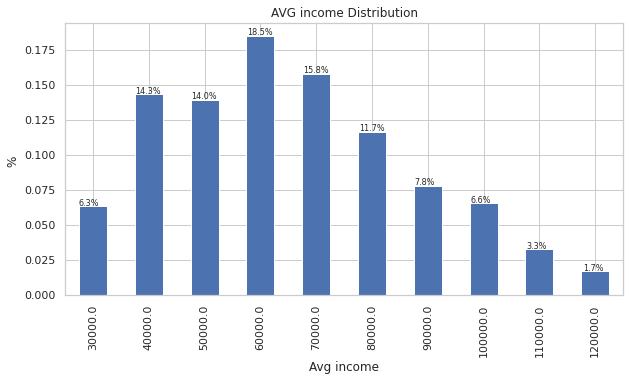

In [17]:
"""Customer income distribution in 10,0000 bands"""


income_Distr=profile.groupby(round(profile.income,-4))['customer_id'].count()
income_Distr_P=(income_Distr/income_Distr.sum()) ###.map(lambda n: '{:,.1%}'.format(n))

plot_bar(data=income_Distr_P,title='AVG income Distribution',xlabel='Avg income', ylabel='% ')

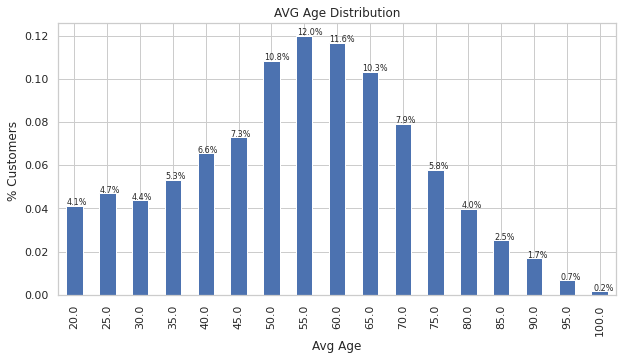

In [18]:
 """Customer Age Distribution in 5 yrs Bands"""
Customer_Age_Distr=profile.groupby(round(profile.age/5,0)*5)['customer_id'].count()
InCustomer_Age_Distr_P=(Customer_Age_Distr/Customer_Age_Distr.sum()) ###.map(lambda n: '{:,.1%}'.format(n))

plot_bar(data=InCustomer_Age_Distr_P,title='AVG Age Distribution',xlabel='Avg Age', ylabel='% Customers ')

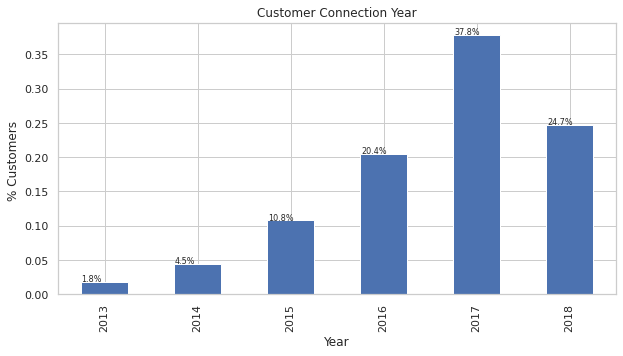

In [19]:
"""Membership Year Distribution"""

Membership_Year=profile.groupby(profile['became_member_on'].dt.to_period('Y'))['customer_id'].count()
Membership_Year_P=(Membership_Year/Membership_Year.sum()) ###.map(lambda n: '{:,.1%}'.format(n))

plot_bar(data=Membership_Year_P,title='Customer Connection Year',xlabel='Year', ylabel='% Customers ')

### Transcript data - events
This is customer transaction/event Data 

In [20]:
transcript.head(7)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0


In [21]:
"""unique events types"""
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [22]:
"""number of each events"""
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [23]:
print(transcript.person.nunique() ,"\n", profile.customer_id.nunique()) 

17000 
 14825


In [24]:
"""Since we droped 13% customers , only keep the one remained"""
Trans_0 = transcript['person'].isin(profile['customer_id'])
transcript = transcript[Trans_0]
print(len(transcript))
print(transcript.person.nunique())
transcript.head(7)

272762
14825


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
12,4b0da7e80e5945209a1fdddfe813dbe0,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0


Lets Explore Customer Transaction behavior

**Transcript file Cleaning requrements**

Data Cleaning:
    - convert Hours to days for time column.

    - value column split transaction value or the offer_id. 

    - rename person to customer_id.

    - handle the categorical values for the event column 

    - proper handling of the different event types in order to validate the completion of offers.

In [25]:
 transcript[transcript['event']=='transaction']

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0
...,...,...,...,...
306526,24f56b5e1849462093931b164eb803b5,transaction,{'amount': 22.64},714
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714


In [26]:
Expenditure = transcript[transcript['event']=='transaction']

In [27]:
Expenditure['amount'] = Expenditure['value'].apply(lambda x: list(x.values())[0])

<ipython-input-27-2b48cf349464>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Expenditure['amount'] = Expenditure['value'].apply(lambda x: list(x.values())[0])


In [28]:
Expenditure

,person,event,value,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97
...,...,...,...,...,...
306526,24f56b5e1849462093931b164eb803b5,transaction,{'amount': 22.64},714,22.64
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,3.61


In [29]:
Expenditure = transcript[transcript['event']=='transaction']

Expenditure['amount'] = Expenditure['value'].apply(lambda x: list(x.values())[0])

Expenditure = Expenditure.drop(['value', 'event'], axis = 1)

Expenditure = Expenditure.rename(columns = {'person': 'customer_id'})

Expenditure = Expenditure.reset_index(drop=True)

Expenditure.head()

<ipython-input-29-3b56d6407561>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Expenditure['amount'] = Expenditure['value'].apply(lambda x: list(x.values())[0])


,customer_id,time,amount
0,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,54890f68699049c2a04d415abc25e717,0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [30]:
Expenditure = pd.merge(Expenditure, profile[['customer_id','gender','age','income']], how='left', on='customer_id')
Expenditure['income']=round(profile.income,-4)
Expenditure['age']=round(profile.age/5,0)*5

In [31]:
Expenditure


,customer_id,time,amount,gender,age,income
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,F,55.0,110000.0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,M,75.0,100000.0
2,54890f68699049c2a04d415abc25e717,0,13.23,M,70.0,70000.0
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,F,65.0,50000.0
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,F,60.0,50000.0
...,...,...,...,...,...,...
123952,24f56b5e1849462093931b164eb803b5,714,22.64,F,NaN,NaN
123953,b3a1272bc9904337b331bf348c3e8c17,714,1.59,M,NaN,NaN
123954,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,M,NaN,NaN
123955,a00058cf10334a308c68e7631c529907,714,3.61,F,NaN,NaN


<AxesSubplot:title={'center':'AVG SPEND'}, xlabel='gender'>

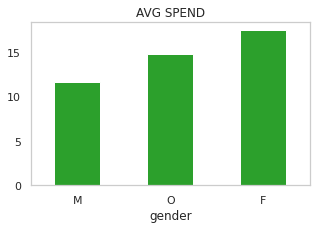

In [32]:
"""AVG SPEND based on Gender"""
Ag_spend=Expenditure.groupby('gender').amount.mean().sort_values()

Ag_spend.plot(kind='bar', rot=0,color='tab:green',figsize=[5,3],grid=False , title='AVG SPEND')

<AxesSubplot:title={'center':'AVG SPEND'}, xlabel='income'>

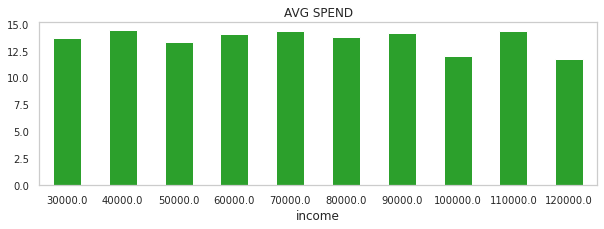

In [33]:
"""AVG SPEND based on Income"""
Ag_spend=Expenditure.groupby('income').amount.mean()#.sort_values()

Ag_spend.plot(kind='bar', rot=0, color='tab:green',figsize=[10,3],grid=False , title='AVG SPEND',fontsize=10)


<AxesSubplot:title={'center':'AVG SPEND'}, xlabel='age'>

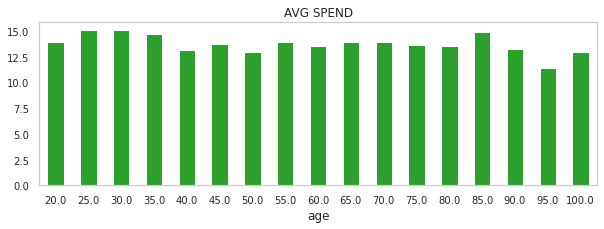

In [34]:
"""AVG SPEND based on Age"""
Ag_spend=Expenditure.groupby('age').amount.mean() #.sort_values()

Ag_spend.plot(kind='bar', rot=0,  color='tab:green',figsize=[10,3],grid=False , title='AVG SPEND',fontsize=10)


In [35]:
"""unpack information in 'value' column"""
values = transcript['value'].apply(pd.Series)
values.offer_id.fillna(values['offer id'], inplace=True)
transcript = pd.concat([transcript, values], axis=1)
transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [36]:
"""calculate number of offers received""" 
Offer_count = transcript[transcript['event']=='offer received'].groupby('person').count().reset_index()
Offer_count.rename(columns={'offer_id':'Offer_count'},inplace=True)
transcript = pd.merge(transcript, Offer_count[['person', 'Offer_count']], how='left', on='person')
transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward,Offer_count
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,4.0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,4.0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,6.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed,NaN,3.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0


In [37]:
"""convert event_types categorical variable into indicator variables"""
event_types = pd.get_dummies(transcript.event)
transcript = pd.concat([transcript, event_types], axis=1)
transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward,Offer_count,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,4.0,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,4.0,0,1,0,0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,6.0,0,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed,NaN,3.0,0,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,0,1,0,0


In [38]:
"""drop and rename columns"""
transcript.drop(['offer id', 'value', 'reward'], axis=1, inplace=True)
transcript.rename(columns={'person':'customer_id'},inplace=True)
transcript.head(3)

,customer_id,event,time,amount,offer_id,Offer_count,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,4.0,0,1,0,0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,6.0,0,1,0,0


In [39]:
"""Explore Single customer data"""
transcript[transcript['customer_id']=='e2127556f4f64592b11af22de27a7932']

,customer_id,event,time,amount,offer_id,Offer_count,offer completed,offer received,offer viewed,transaction
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,4.0,0,1,0,0
17760,e2127556f4f64592b11af22de27a7932,offer viewed,18,NaN,2906b810c7d4411798c6938adc9daaa5,4.0,0,0,1,0
91402,e2127556f4f64592b11af22de27a7932,transaction,288,17.88,NaN,4.0,0,0,0,1
92480,e2127556f4f64592b11af22de27a7932,transaction,294,21.43,NaN,4.0,0,0,0,1
98717,e2127556f4f64592b11af22de27a7932,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,4.0,0,1,0,0
133962,e2127556f4f64592b11af22de27a7932,offer received,408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,1,0,0
152024,e2127556f4f64592b11af22de27a7932,offer viewed,420,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,0,1,0
179364,e2127556f4f64592b11af22de27a7932,offer received,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,4.0,0,1,0,0
199950,e2127556f4f64592b11af22de27a7932,offer viewed,522,NaN,fafdcd668e3743c1bb461111dcafc2a4,4.0,0,0,1,0
199951,e2127556f4f64592b11af22de27a7932,transaction,522,18.42,NaN,4.0,0,0,0,1


In [40]:
"""Merge transcript and portfolio Dataframes using Offer_Id"""

starbucks_df = pd.merge(transcript, portfolio, how='left', on='offer_id')
starbucks_df.groupby(['offer_type', 'event']).customer_id.count()

offer_type     event          
bogo           offer completed    15258
               offer received     26537
               offer viewed       22039
discount       offer completed    17186
               offer received     26664
               offer viewed       18461
informational  offer received     13300
               offer viewed        9360
Name: customer_id, dtype: int64

In [41]:
starbucks_df.head()

,customer_id,event,time,amount,offer_id,Offer_count,offer completed,offer received,offer viewed,transaction,...,duration,offer_type,web,email,social,mobile,offer,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,1,0,0,...,7.0,bogo,1.0,1.0,0.0,1.0,bogo_5_for_5_in_7days,1.0,0.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,4.0,0,1,0,0,...,7.0,discount,1.0,1.0,0.0,1.0,discount_2_for_10_in_7days,0.0,1.0,0.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,6.0,0,1,0,0,...,5.0,bogo,1.0,1.0,1.0,1.0,bogo_5_for_5_in_5days,1.0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,3.0,0,1,0,0,...,4.0,informational,1.0,1.0,0.0,1.0,informational_0_for_0_in_4days,0.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,0,1,0,0,...,10.0,discount,1.0,1.0,0.0,0.0,discount_5_for_20_in_10days,0.0,1.0,0.0


/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


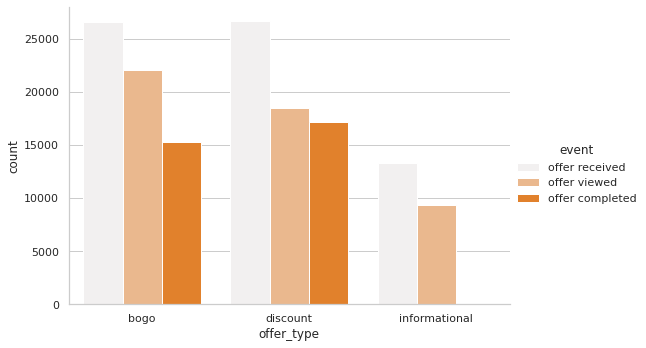

In [42]:
"""Plot Offers to get Status count for each offer"""
events_by_offer_type = sns.factorplot(data=starbucks_df[starbucks_df['event']!='transaction'], x='offer_type',
                                   kind='count', hue='event', aspect=1.5,color='tab:orange')

### Data Prep

define which outcomes can be classified as success/Failure  
As BOGO and discount offers have 'offer completed' events while informational offers have not,
prepare data for the offer types separately, starting out with BOGO and discount offers.

- BOGO and Discount Offers Status
1. **successful offer**: offer received → viewed → transaction(s) → offer completed
2. **ineffective offer**: offer received → viewed
3. **unviewed offer**: offer received
4. **unviewed success**: offer received → transaction(s) → offer completed

In [43]:
def get_offer_completion(df):
    '''
    cleans dataframe for further analysis based on offer completion
    
    INPUT:
    df - the dataframe to be cleaned
    
    OUTPUT:
    starbucks_df - the cleaned dataframe
    
    ''' 
    pd.options.mode.chained_assignment = None
    
    """ identify success cases in 'offer completed' rows """

    completed_offer = df[['customer_id', 'event', 'time', 'offer_id', 'Offer_count']].sort_values(['customer_id','time'])
    completed_offer = completed_offer[(completed_offer['event']=='offer viewed') | (completed_offer['event']=='offer completed')]
    
    """shift() - what this does now shifts first row to next row and put as first row as NaN. way it performs depends on condition.
      Using this we can filter groups based on customer id and offer_id, and apply shift() to have reference offer_id in column previous_offer_id
     this is helpful when filtering based on offer completed, so that we get success cond, where offer is completed and that is viewed """
    completed_offer['previous_offer_id'] = completed_offer.groupby(['customer_id', 'offer_id'])['offer_id'].shift()
    
    """success if offer is completed and is viewed then 1 else 0"""
    completed_offer['success'] = np.where((completed_offer['event'] == 'offer completed')
                                           & (completed_offer['previous_offer_id'] == completed_offer['offer_id']),
                                           1, 0)
    """success withought being viewed if offer is completed but not viewed then 1 or else 0"""
    completed_offer['success_notviewed'] = np.where((completed_offer['event'] == 'offer completed')
                                                    & (completed_offer['previous_offer_id'].isna()),
                                                    1, 0)
    completed_offer.drop(['previous_offer_id'], axis=1, inplace=True)
    
    """re-include 'offer received' rows"""
    received_offers = df[['customer_id', 'event', 'time', 'offer_id', 'Offer_count']][df['event']=='offer received'].sort_values(['customer_id','time'])
    
    together = received_offers.append(completed_offer).sort_values(['customer_id','time'])
    together = together.sort_values(['customer_id','time'])
    
    """transmit information from 'offer completed' to corresponding 'offer received' rows"""
    successes = together[(together['event']=='offer received') | (together['event']=='offer completed')]
    successes['success'] = successes.groupby(['customer_id', 'offer_id'])['success'].bfill()
    successes['success_notviewed'] = successes.groupby(['customer_id', 'offer_id'])['success_notviewed'].bfill()
    result = successes[successes['event']=='offer received']
    
    """classify remaining offers as failures and fill missings"""
    result['failure'] = np.where((result['success'].isna()) & (result['success_notviewed'].isna()), 1, 0)
    # fill missing values with 0
    result['success'] = np.where(result['success'].isna(), 0, result['success'])
    
    result['success'] = result['success'].astype('int')
    result['success_notviewed'] = np.where(result['success_notviewed'].isna(), 0, result['success_notviewed'])
    result['success_notviewed'] = result['success_notviewed'].astype('int')
    
    """build categorical outcome column"""
    result['outcome'] = np.where(result['success'] == 1, 'success',
                                 np.where(result['success_notviewed'] == 1, 'unviewed success', 'failure'))

    outcome_map = {'failure': 0, 'unviewed success': 1, 'success': 2}
    result['outcome_factor'] = result['outcome'].map(outcome_map)
    
    """add customer and offer information""" 
    starbucks_df = pd.merge(result, portfolio, how='left', on='offer_id')
    starbucks_df = pd.merge(starbucks_df, profile, how='left', on='customer_id')
    starbucks_df.drop(['event', 'became_member_on'], axis=1, inplace=True)
    
    pd.options.mode.chained_assignment = "warn"
    
    return starbucks_df

In [44]:
starbucks_df

,customer_id,event,time,amount,offer_id,Offer_count,offer completed,offer received,offer viewed,transaction,...,duration,offer_type,web,email,social,mobile,offer,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,1,0,0,...,7.0,bogo,1.0,1.0,0.0,1.0,bogo_5_for_5_in_7days,1.0,0.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,4.0,0,1,0,0,...,7.0,discount,1.0,1.0,0.0,1.0,discount_2_for_10_in_7days,0.0,1.0,0.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,6.0,0,1,0,0,...,5.0,bogo,1.0,1.0,1.0,1.0,bogo_5_for_5_in_5days,1.0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,3.0,0,1,0,0,...,4.0,informational,1.0,1.0,0.0,1.0,informational_0_for_0_in_4days,0.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,0,1,0,0,...,10.0,discount,1.0,1.0,0.0,0.0,discount_5_for_20_in_10days,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,24f56b5e1849462093931b164eb803b5,offer completed,714,NaN,fafdcd668e3743c1bb461111dcafc2a4,3.0,1,0,0,0,...,10.0,discount,1.0,1.0,1.0,1.0,discount_2_for_10_in_10days,0.0,1.0,0.0
272758,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,3.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272759,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,5.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272760,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,5.0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
bogo = starbucks_df[starbucks_df['offer_type']=='bogo']
discount = starbucks_df[starbucks_df['offer_type']=='discount']
bogo_discount_notcleaned = bogo.append(discount)

<ipython-input-45-4e3b7bd08b86>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bogo_discount_notcleaned = bogo.append(discount)


In [46]:
bogo_cleaned = get_offer_completion(bogo)
discount_cleaned = get_offer_completion(discount)
bogo_discount = bogo_cleaned.append(discount_cleaned)
bogo_discount.head(10)

<ipython-input-43-dea4155a7a98>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  together = received_offers.append(completed_offer).sort_values(['customer_id','time'])
<ipython-input-43-dea4155a7a98>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  together = received_offers.append(completed_offer).sort_values(['customer_id','time'])
<ipython-input-46-d0cb9337e504>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bogo_discount = bogo_cleaned.append(discount_cleaned)


,customer_id,time,offer_id,Offer_count,success,success_notviewed,failure,outcome,outcome_factor,reward,...,social,mobile,offer,bogo,discount,informational,gender,age,income,membership_Tenure
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,unviewed success,1,5,...,1,1,bogo_5_for_5_in_5days,1,0,0,M,33,72000.0,461
1,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,success,2,5,...,0,1,bogo_5_for_5_in_7days,1,0,0,O,40,57000.0,198
2,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,0,1,failure,0,10,...,1,1,bogo_10_for_10_in_7days,1,0,0,F,59,90000.0,874
3,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,1,0,0,success,2,10,...,1,1,bogo_10_for_10_in_5days,1,0,0,F,59,90000.0,874
4,0020ccbbb6d84e358d3414a3ff76cffd,336,f19421c1d4aa40978ebb69ca19b0e20d,4.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,1,0,0,F,24,60000.0,622
5,0020ccbbb6d84e358d3414a3ff76cffd,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,1,0,0,success,2,5,...,0,1,bogo_5_for_5_in_7days,1,0,0,F,24,60000.0,622
6,004b041fbfe44859945daa2c7f79ee64,504,f19421c1d4aa40978ebb69ca19b0e20d,3.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,1,0,0,F,55,74000.0,79
7,004c5799adbf42868b9cff0396190900,336,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,1,0,unviewed success,1,10,...,1,1,bogo_10_for_10_in_7days,1,0,0,M,54,99000.0,847
8,004c5799adbf42868b9cff0396190900,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,1,0,0,M,54,99000.0,847
9,004c5799adbf42868b9cff0396190900,504,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0,0,success,2,5,...,1,1,bogo_5_for_5_in_5days,1,0,0,M,54,99000.0,847


In [47]:
def get_offer_info_tranx(df):
    '''
    cleans dataframe for further analysis based on transactions within validity period
    
    INPUT:
    df - the dataframe to be cleaned
    
    OUTPUT:
    temp3 - the cleaned dataframe
    
    ''' 
    temp3 = df.sort_values(['customer_id','time'])

    """calculate remaining time for offers"""
    temp3['duration_hrs'] = temp3.duration * 24
    
    """ if offer recieved then temp3['time'] + temp3['duration_hrs'] or nan """
    temp3['end_time'] = np.where(temp3['event']=='offer received', temp3['time'] + temp3['duration_hrs'], np.nan)
    temp3['end_time'] = temp3.groupby('customer_id')['end_time'].ffill()
    temp3['remaining'] = temp3['end_time'] - temp3.time
    
    temp3['offer'] = np.where((temp3['event']=='transaction') & (temp3['remaining']>=0), temp3['offer'].ffill(), temp3.offer)

    """ get rid of all transactions that do not belong to an offer"""
    temp3 = temp3[-temp3['offer'].isna()]


    """calculate transaction sum during offer validity period using transactions and offer viewed"""
    temp3_rest = temp3[(temp3['event']=='offer viewed')|(temp3['event']=='transaction')]
    uff = pd.DataFrame(temp3_rest.groupby(['customer_id','offer'])['amount'].sum())
    uff.rename(columns={'amount':'sum'},inplace=True)
    temp3_rest_sum = pd.merge(temp3_rest, uff, how='left', on=['customer_id','offer'])
    temp3_rest_sum['amount'] = np.where(temp3_rest_sum['event']=='offer viewed', temp3_rest_sum['sum'], temp3_rest_sum['amount'])
    temp3 = temp3[temp3['event']=='offer received'].append(temp3_rest_sum).sort_values(['customer_id','time'])
    temp3 = temp3.drop(columns=['duration_hrs', 'end_time', 'remaining', 'sum'])

    """"transfer transaction sum to 'offer received' rows"""
    temp3 = temp3[-(temp3['event']=='transaction')]
    temp3['amount'] = temp3.groupby(['customer_id','offer'])['amount'].shift(-1)
    temp3 = temp3[temp3['event']=='offer received']
    temp3['amount'] = temp3['amount'].fillna(0)
    
    """"add success indicator""" 
    temp3['success'] = np.where(temp3['amount']>0,1,0)
    temp3['success_notviewed'] = -99
    temp3['failure'] = -99
    temp3['outcome'] = -99
    temp3['outcome_factor'] = -99
    
    """add customer profile"""
    temp3 = pd.merge(temp3, profile, how='left', on='customer_id')
    temp3.drop(['event', 'became_member_on'], axis=1, inplace=True)

    return temp3

In [48]:
info = starbucks_df[(starbucks_df['offer_type']=='informational') |(starbucks_df['event']=='transaction')]

In [49]:
info_cleaned = get_offer_info_tranx(info)
info_cleaned.head(10)

<ipython-input-47-a709e93006d8>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp3 = temp3[temp3['event']=='offer received'].append(temp3_rest_sum).sort_values(['customer_id','time'])


,customer_id,time,amount,offer_id,Offer_count,offer completed,offer received,offer viewed,transaction,reward,...,informational,success,success_notviewed,failure,outcome,outcome_factor,gender,age,income,membership_Tenure
0,0009655768c64bdeb2e877511632db8f,168,22.16,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,M,33,72000.0,461
1,0009655768c64bdeb2e877511632db8f,336,8.57,3f207df678b143eea3cee63160fa8bed,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,M,33,72000.0,461
2,0011e0d4e6b944f998e987f904e8c1e5,0,0.00,3f207df678b143eea3cee63160fa8bed,5.0,0,1,0,0,0.0,...,1.0,0,-99,-99,-99,-99,O,40,57000.0,198
3,0011e0d4e6b944f998e987f904e8c1e5,336,0.00,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0,0.0,...,1.0,0,-99,-99,-99,-99,O,40,57000.0,198
4,0020c2b971eb4e9188eac86d93036a77,504,51.10,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,F,59,90000.0,874
5,0020ccbbb6d84e358d3414a3ff76cffd,408,58.87,5a8bc65990b245e5a138643cd4eb9837,4.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,F,24,60000.0,622
6,003d66b6608740288d6cc97a6903f4f0,0,2.51,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,F,26,73000.0,400
7,003d66b6608740288d6cc97a6903f4f0,336,12.27,3f207df678b143eea3cee63160fa8bed,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,F,26,73000.0,400
8,00426fe3ffde4c6b9cb9ad6d077a13ea,0,25.92,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0,0.0,...,1.0,1,-99,-99,-99,-99,F,19,65000.0,716
9,004b041fbfe44859945daa2c7f79ee64,168,0.00,3f207df678b143eea3cee63160fa8bed,3.0,0,1,0,0,0.0,...,1.0,0,-99,-99,-99,-99,F,55,74000.0,79


Merge data set to be used to build classification model.

In [50]:
info_test = info_cleaned.drop(columns=['amount'])
starbucks_cl_df = bogo_discount.append(info_test)
starbucks_cl_df.head()

<ipython-input-50-f1a41b0936bc>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  starbucks_cl_df = bogo_discount.append(info_test)


,customer_id,time,offer_id,Offer_count,success,success_notviewed,failure,outcome,outcome_factor,reward,...,discount,informational,gender,age,income,membership_Tenure,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,unviewed success,1,5.0,...,0.0,0.0,M,33,72000.0,461,NaN,NaN,NaN,NaN
1,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,success,2,5.0,...,0.0,0.0,O,40,57000.0,198,NaN,NaN,NaN,NaN
2,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,0,1,failure,0,10.0,...,0.0,0.0,F,59,90000.0,874,NaN,NaN,NaN,NaN
3,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,1,0,0,success,2,10.0,...,0.0,0.0,F,59,90000.0,874,NaN,NaN,NaN,NaN
4,0020ccbbb6d84e358d3414a3ff76cffd,336,f19421c1d4aa40978ebb69ca19b0e20d,4.0,1,0,0,success,2,5.0,...,0.0,0.0,F,24,60000.0,622,NaN,NaN,NaN,NaN


In [51]:
starbucks_cl_df=starbucks_cl_df.fillna(0);

In [52]:
starbucks_cl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 13299
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        66501 non-null  object 
 1   time               66501 non-null  int64  
 2   offer_id           66501 non-null  object 
 3   Offer_count        66501 non-null  float64
 4   success            66501 non-null  int64  
 5   success_notviewed  66501 non-null  int64  
 6   failure            66501 non-null  int64  
 7   outcome            66501 non-null  object 
 8   outcome_factor     66501 non-null  int64  
 9   reward             66501 non-null  float64
 10  difficulty         66501 non-null  float64
 11  duration           66501 non-null  float64
 12  offer_type         66501 non-null  object 
 13  web                66501 non-null  float64
 14  email              66501 non-null  float64
 15  social             66501 non-null  float64
 16  mobile             665

### offer perfomance

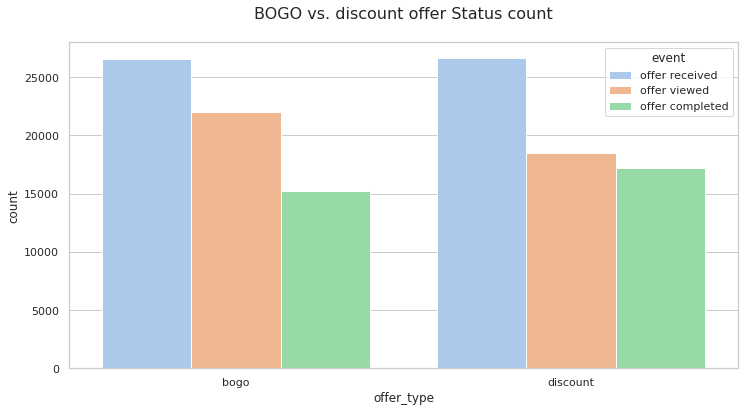

In [53]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(x="offer_type", hue="event", data=bogo_discount_notcleaned, palette="pastel")
plt.title("BOGO vs. discount offer Status count\n", fontsize=16);

In [54]:
def event_counts(df):
    """
    output:
    returns the counts of each individual event
    Input:
    df: dataframe
    """
    events = df['event'].unique()
    counts = []
    for event in events:
        count = len(df[df['event'] == event])
        yield count

In [55]:
"""BOGO offer status counts"""
bogo_received, bogo_viewed, bogo_completed = event_counts(bogo)

"""discount offer status count"""
discount_received, discount_viewed, discount_completed = event_counts(discount)

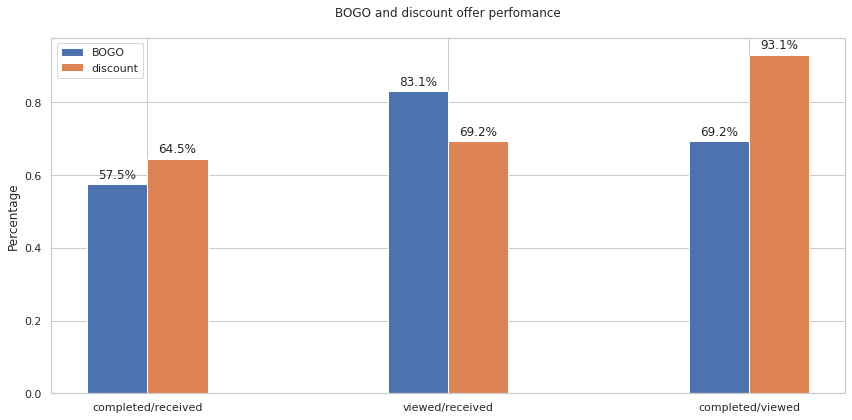

In [56]:
labels = ['completed/received', 'viewed/received', 'completed/viewed']
bogo_performance = [bogo_completed/bogo_received, bogo_viewed/bogo_received, bogo_completed/bogo_viewed]
discount_performance = [discount_completed/discount_received, discount_viewed/discount_received, discount_completed/discount_viewed]

x = np.arange(len(labels))  # lable
width = 0.2  # bars width

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, bogo_performance, width, label='BOGO')
rects2 = ax.bar(x + width/2, discount_performance, width, label='discount')

ax.set_ylabel('Percentage')
ax.set_title('BOGO and discount offer perfomance\n', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(round(height*100,1)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [57]:
pd.DataFrame(starbucks_cl_df.groupby(['offer'])['success'].mean()).reset_index().sort_values('success', ascending=False)

,offer,success
4,discount_2_for_10_in_10days,0.691371
6,discount_3_for_7_in_7days,0.665214
8,informational_0_for_0_in_3days,0.640373
2,bogo_5_for_5_in_5days,0.563108
0,bogo_10_for_10_in_5days,0.457455
1,bogo_10_for_10_in_7days,0.435583
9,informational_0_for_0_in_4days,0.382605
3,bogo_5_for_5_in_7days,0.374869
5,discount_2_for_10_in_7days,0.367667
7,discount_5_for_20_in_10days,0.243533


**This also shows that discount offer is better performing than Bogo offer.**

## Predicting Offer Success

In [58]:
def offer_success_classifier(df, target, target_names,
                               model=RandomForestClassifier(max_depth=20, random_state=42)):
    '''
    Builds classification model
    
    INPUT:
    df - the dataframe to be analyzed
    target - the outcome variable
    target_names - labels for the target values
    model - the model (default: random forest classification with max tree depth of 20, random state of 42)
    
    OUTPUT:
    model - the classification model
    
    '''
    df = df.dropna(how='any', axis=0)
    
    gender = pd.get_dummies(df.gender)
    df = pd.concat([df, gender], axis=1)
    
    X = df.drop(columns=['customer_id', 'offer_id', 'time', 'offer_type', 'gender','offer',
                         'success', 'success_notviewed', 'failure', 'outcome', 'outcome_factor',
                        'offer completed','offer received','offer viewed','transaction'])
    y = df.pop(target)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    model = model

    model.fit(X_train, y_train)
    
    model_predictions = model.predict(X_test)
    print(classification_report(y_test, model_predictions, target_names=target_names))
    
    print("Overall model accuracy:\t {}".format(accuracy_score(y_test, model_predictions)))
    
    train_probs = model.predict_proba(X_train)
    model_probs = model.predict_proba(X_test)
    print("Train ROC AUC score:\t {}".format(roc_auc_score(y_train, train_probs[:, 1])))
    print("Test ROC AUC score:\t {}".format(roc_auc_score(y_test, model_probs[:, 1])))
    
    return model

In [59]:
cl_model=offer_success_classifier(starbucks_cl_df, 'success', ['failure', 'success'])

              precision    recall  f1-score   support

     failure       0.72      0.71      0.71     10390
     success       0.69      0.69      0.69      9561

    accuracy                           0.70     19951
   macro avg       0.70      0.70      0.70     19951
weighted avg       0.70      0.70      0.70     19951

Overall model accuracy:	 0.702821913688537
Train ROC AUC score:	 0.9962036298569369
Test ROC AUC score:	 0.7675285756953552


In [60]:
model_gb = offer_success_classifier(starbucks_cl_df, 'success', ['failure', 'success'],GradientBoostingClassifier(random_state=42))

              precision    recall  f1-score   support

     failure       0.69      0.71      0.70     10390
     success       0.68      0.66      0.67      9561

    accuracy                           0.69     19951
   macro avg       0.69      0.68      0.68     19951
weighted avg       0.69      0.69      0.69     19951

Overall model accuracy:	 0.6857300385945566
Train ROC AUC score:	 0.7545997663725021
Test ROC AUC score:	 0.7526661639426049


In [61]:
adab_model = offer_success_classifier(starbucks_cl_df, 'success', ['failure', 'success'],AdaBoostClassifier(random_state=42))

              precision    recall  f1-score   support

     failure       0.68      0.68      0.68     10390
     success       0.66      0.66      0.66      9561

    accuracy                           0.67     19951
   macro avg       0.67      0.67      0.67     19951
weighted avg       0.67      0.67      0.67     19951

Overall model accuracy:	 0.6710941807428199
Train ROC AUC score:	 0.7295966493333714
Test ROC AUC score:	 0.7299133701950669


GradientBoostingClassifier and AdaBoostClassifier perfomance are a bit performing better without offerfitting. we will proceed with AdaBoostClassifier for now.

### Hyperparameter Tuning

In [62]:
adab_model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

In [63]:
param_grid={'n_estimators': [50, 100, 500],
            'learning_rate': [0.1,0.7, 1],
             'algorithm': ['SAMME.R','SAMME']}

cv = GridSearchCV(adab_model, param_grid=param_grid, n_jobs=-1, scoring = 'roc_auc')

full_data_prep = starbucks_cl_df.dropna(how='any', axis=0)    
gender = pd.get_dummies(full_data_prep.gender)
full_data_prep = pd.concat([full_data_prep, gender], axis=1)

X = full_data_prep.drop(columns=['customer_id', 'offer_id', 'time', 'offer_type', 'gender','offer',
                         'success', 'success_notviewed', 'failure', 'outcome', 'outcome_factor',
                        'offer completed','offer received','offer viewed','transaction'])
y = full_data_prep.pop('success')
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

score = cv.fit(X_train, y_train)

score.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 500}

In [64]:
optimal_Model = AdaBoostClassifier(n_estimators=500,learning_rate=0.1,algorithm='SAMME.R',random_state=42)
Final_Model = offer_success_classifier(starbucks_cl_df, 'success', ['failure', 'success'], model=optimal_Model)

              precision    recall  f1-score   support

     failure       0.68      0.68      0.68     10390
     success       0.65      0.66      0.65      9561

    accuracy                           0.67     19951
   macro avg       0.67      0.67      0.67     19951
weighted avg       0.67      0.67      0.67     19951

Overall model accuracy:	 0.6689890231066112
Train ROC AUC score:	 0.7295248849870593
Test ROC AUC score:	 0.7302833968483006


In [65]:
def most_important_features(df, model):
    '''
    identifies most important features
    
    INPUT:
    df - the dataframe used to train and test the model
    model - the classification model
    
    OUTPUT:
    feat_imp - an ordered dataframe consisting of all features and importance
    
    '''
    df = df.dropna(how='any', axis=0)
    
    gender = pd.get_dummies(df.gender)
    df = pd.concat([df, gender], axis=1)
    
    X = df.drop(columns=['customer_id', 'offer_id', 'time', 'offer_type', 'gender','offer',
                         'success', 'success_notviewed', 'failure', 'outcome', 'outcome_factor',
                        'offer completed','offer received','offer viewed','transaction'])
    
    feat_imp = pd.DataFrame(model.feature_importances_, index=X.columns,
                            columns=['importance']).sort_values('importance', ascending=False).reset_index()
    feat_imp.rename(columns={'index':'feature'},inplace=True)
    
    plot = sns.factorplot(data=feat_imp.reset_index(), y='feature', x='importance', kind='bar', aspect=2)
    plot.set(title='Feature importance')
    
    return feat_imp

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


,feature,importance
0,membership_Tenure,0.202
1,age,0.160
2,income,0.144
3,duration,0.106
4,social,0.096
5,difficulty,0.082
6,reward,0.068
7,mobile,0.042
8,M,0.036
9,O,0.026


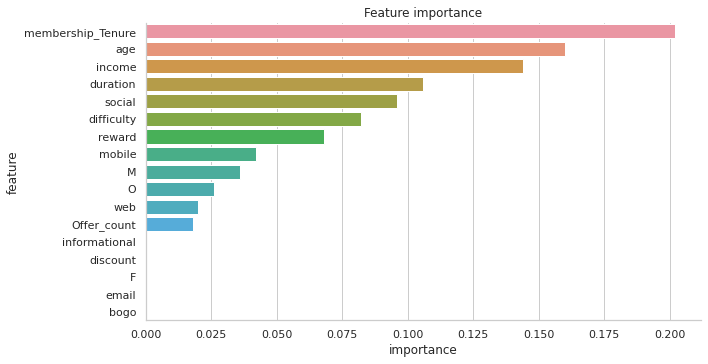

In [66]:
most_important_features(starbucks_cl_df, Final_Model)

<AxesSubplot:title={'center':'AVG SPEND'}, xlabel='success'>

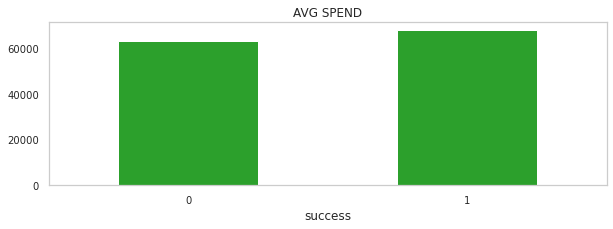

In [67]:
Success_rate=starbucks_cl_df.groupby('success')['income'].mean()#.sort_values()

Success_rate.plot(kind='bar', rot=0,  color='tab:green',figsize=[10,3],grid=False , title='AVG SPEND',fontsize=10)

In [68]:
starbucks_cl_df.groupby('success')['income'].mean()

success
0    63151.442168
1    67759.699117
Name: income, dtype: float64

Offers are more likely to be successful for members with higher incomes.

In [69]:
starbucks_cl_df.groupby(['social'])['success'].mean()

social
0.0    0.341923
1.0    0.575599
Name: success, dtype: float64

Offers are more likely to be successful via the channel 'social'.

## Conclusion
- From this Experiment we see the opportunity to improve Starbucks campaign using ML model by recommending which offer to present to a customer
- However to further measure the success there should be control group.
- We can keep explore other modeling techniques and algorithms for better improvement.
- A deep dive analysis need to be done to understand more the effect of all variable for offer success.